# Задача 3
Решить краевую задачу\
$
\begin{cases}
    y'' + (x^2 - 3)y' + (x^2 - 3)\cos x \cdot y = 2 - 6x + 2x^3 + (x^2 - 3)e^x \sin x (1 + \cos x) + \cos x (e^x + (x^2-1) + x^4 - 3x^2)\\
    y(0) = 0\\
    y(\pi) = \pi ^ 2
\end{cases}
$

## 1. Метод прогонки
**Метод неустойчивый!**\
Задача линейная, дискретизуем и сводем к системе линейных уравнений, которую решим методом прогонки\
$
\begin{cases}
    y'' + g(x)y' + h(x)\cdot y = f(x)\\
    y(0) = 0\\
    y(\pi) = \pi ^ 2
\end{cases}
$

In [2]:
from math import exp, sin, cos, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# метод прогонки (tridiagonal matrix algorithm)
def TMA(a_arr, b_arr, c_arr, d_arr):
    N_pr = len(a_arr)
    p_arr = [0] * N_pr
    q_arr = [0] * N_pr
    x_arr = [0] * N_pr

    # i = 0
    p_arr[1] = -c_arr[0] / b_arr[0]
    q_arr[1] = d_arr[0] / b_arr[0]

    # i = 1, ..., N - 1
    for i in range(2, N_pr, 1):
        p_arr[i] = -c_arr[i - 1] / (a_arr[i - 1] * p_arr[i - 1] + b_arr[i - 1])
        q_arr[i] = (d_arr[i - 1] - a_arr[i - 1] * q_arr[i - 1]) / (a_arr[i - 1] * p_arr[i - 1] + b_arr[i - 1])

    x_arr[N_pr - 1] = (d_arr[N_pr - 1] - a_arr[N_pr - 1] * q_arr[N_pr - 1]) / (p_arr[N_pr - 1] * a_arr[N_pr - 1] + b_arr[N_pr - 1])
    
    # обратный ход
    for i in range(N_pr - 2, -1, -1):
        x_arr[i] = x_arr[i + 1] * p_arr[i + 1] + q_arr[i + 1]
    
    return x_arr


# функции (коэффициенты в уравнении)
def g(x):
    # x - точка
    # y - начальное приближение в точке x
    # y_der1 - производная начального приближения в точке x
    # y_der2 - вторая производная начального приближения в точке x
    return x ** 2 - 3

def h(x):
    return (x ** 2 - 3) * cos(x)

def f(x):
    return 2 - 6 * x + 2 * x ** 3 + (x ** 2 - 3) * exp(x) * sin(x) * (1 + cos(x)) + cos(x) * (exp(x) + (x ** 2 - 1) + x ** 4 - 3 * x ** 2)


# вектор-функции (коэффициенты в уравнении)
def g_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = g(x_arr[i])
    return ret

def h_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = h(x_arr[i])
    return ret

def f_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = f(x_arr[i])
    return ret


# коэффициенты для матрицы из метода прогонки
def a_n(tau, g_n, h_n, f_n):
    return 1 + tau * g_n

def b_n(tau, g_n, h_n, f_n):
    return -2 - tau * g_n + tau ** 2 * h_n

def c_n(tau, g_n, h_n, f_n):
    return 1

def d_n(tau, g_n, h_n, f_n):
    return tau ** 2 * f_n


# векторы коэффициентов для матрицы из метода прогонки
def a_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # a(0) = a(N) = 0, a(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    for i in range(1, N - 1, 1):
        ret[i] = a_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def b_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # b(0) = b(N) = 1, b(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [1] * N
    for i in range(1, N - 1, 1):
        ret[i] = b_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def c_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # c(0) = c(N) = 0, c(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    for i in range(1, N - 1, 1):
        ret[i] = c_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def d_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # d(0) = 0, d(N) = pi ** 2, d(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    ret[-1] = pi ** 2
    for i in range(1, N - 1, 1):
        ret[i] = d_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret


In [4]:
# сетка
x_start = 0
x_end = pi
N_grid = 1000 + 1
x_grid, tau = np.linspace(x_start, x_end, N_grid, retstep=True)

# проекция на сетку функций (коэффициентов в уравнении)
g_grid = g_vec(x_grid)
h_grid = h_vec(x_grid)
f_grid = f_vec(x_grid)

# коэффициенты матрицы для метода прогонки
a_arr = a_n_vec(tau, g_grid, h_grid, f_grid)
b_arr = b_n_vec(tau, g_grid, h_grid, f_grid)
c_arr = c_n_vec(tau, g_grid, h_grid, f_grid)
d_arr = d_n_vec(tau, g_grid, h_grid, f_grid)

# метод прогонки
y_vect = TMA(a_arr, b_arr, c_arr, d_arr)
print(min(y_vect), max(y_vect))

0.0 9.869604401089358


In [5]:
print(min(h_grid), max(h_grid))

-6.869604401089358 0.021973765882872493


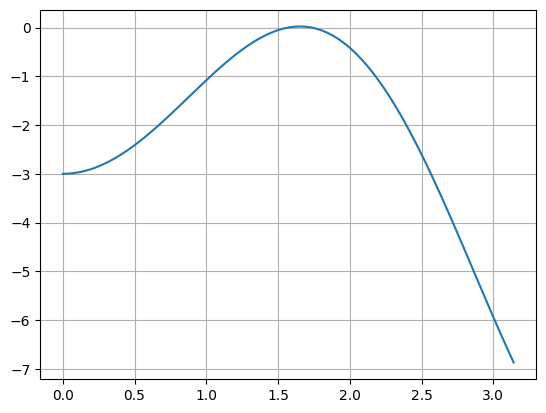

In [6]:
plt.plot(x_grid, h_grid)
plt.grid()

т.к. условие $h(x) < 0$ выполнено не для любого $x$, то метод **неустойчивый!**

## 2. Метод пристрелки
Пусть $y' = \upsilon$, тогда \
$
\begin{cases}
   y' = \upsilon \\
   \upsilon ' + (x^2 - 3) \upsilon + (x^2 - 3)\cos x \cdot y = h(x)\\
   y(0) = 0\\
   y(\pi) = \pi ^ 2
\end{cases}
$\
Перейдем к задаче Коши:\
$
\begin{cases}
   y' = \upsilon \\
   \upsilon ' = - (x^2 - 3) \upsilon - (x^2 - 3)\cos x \cdot y + h(x)\\
   y(0) = 0\\
   \upsilon(0) = \alpha
\end{cases}
$ \
Переобозначим $x \rightarrow t; y \rightarrow x; \upsilon \rightarrow y$\
$
\begin{cases}
   x' = y = f(t, x, y)\\
   y' = - (t^2 - 3) y - (t^2 - 3)\cos t \cdot x + h(t) = g(t, x, y)\\
   x(0) = 0\\
   y(0) = \alpha
\end{cases}
$ \
Решаем систему методом Рунге-Кутты (классическая схема 4 порядка).  Подбор параметра $\alpha$ производим методом половинного деления

In [1]:
from math import sqrt
import numpy as np
import pandas as pd

Задаем функции

In [7]:
def f(t, x, y):
    return y

def g(t, x, y):
    return -(t ** 2 - 3) * y - (t ** 2 - 3) * cos(t) * x + 2 - 6 * t + 2 * t ** 3 + (t ** 2 - 3) * exp(t) * sin(t) * (1 + cos(t)) + cos(t) * (exp(t) + (t ** 2 - 1) + t ** 4 - 3 * t ** 2)

Метод Рунги-Кутты

In [29]:
def ODE(t_grid, tau, x_0, y_0, t_check):
    x_n = x_0
    y_n = y_0
    x_check = []
    y_check = []
    i_check = 0
    for i in range(len(t_grid) - 1):
        k1 = f(t_grid[i], x_n, y_n)
        m1 = g(t_grid[i], x_n, y_n)
        k2 = f(t_grid[i] + tau / 2, x_n + tau / 2 * k1, y_n + tau / 2 * m1)
        m2 = g(t_grid[i] + tau / 2, x_n + tau / 2 * k1, y_n + tau / 2 * m1)
        k3 = f(t_grid[i] + tau / 2, x_n + tau / 2 * k2, y_n + tau / 2 * m2)
        m3 = g(t_grid[i] + tau / 2, x_n + tau / 2 * k2, y_n + tau / 2 * m2)
        k4 = f(t_grid[i] + tau, x_n + tau * k3, y_n + tau * m3)
        m4 = g(t_grid[i] + tau, x_n + tau * k3, y_n + tau * m3)
        x_n = x_n + tau / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        y_n = y_n + tau / 6 * (m1 + 2 * m2 + 2 * m3 + m4)

        if i_check < len(t_check) and abs(t_grid[i] - t_check[i_check]) < 1e-10:
            x_check.append(x_n)
            y_check.append(y_n)
            i_check += 1
    return x_n, y_n, x_check, y_check

Решаем задачу



In [36]:
# точность
eps = 1e-6

# сетка
t_start = 0
t_end = pi
x_start = 0
x_end_target = pi ** 2

N = 10 ** 4 + 1
t_grid, tau = np.linspace(t_start, t_end, N, retstep=True)

# точки для вывода функции
t_check_base = [0.5, 1, 1.5, 2, 2.5, 3]
i_check_base = 0
t_check = []
for i in t_grid:
    if t_check_base[i_check_base] < i:
        t_check.append(i)
        i_check_base += 1
    if i_check_base == len(t_check_base):
        break

# определение минимального и максимального значений параметра alpha
alpha_min = 0
alpha_max = 1
x_end_min, y_end_min, _, _ = ODE(t_grid, tau, x_start, alpha_min, t_check)
x_end_max, y_end_max, _, _ = ODE(t_grid, tau, x_start, alpha_max, t_check)
print()
print(f"x_target = {x_end_target:.2f}")
print(f"alpha = {alpha_min}, x_end = {x_end_min:.2f}")
print(f"alpha = {alpha_max}, x_end = {x_end_max:.2f}")

# деление пополам, пока x на правом конце отрезка не достигнет заданной точности
alpha_table = [alpha_min, alpha_max]
x_end_table = [ODE(t_grid, tau, x_start, alpha_min, t_check)[0], ODE(t_grid, tau, x_start, alpha_max, t_check)[0]]
x_end_i = x_end_table[-1]
x_check = []
while abs(x_end_i - x_end_target) > eps:
    alpha = (alpha_min + alpha_max) / 2
    x_end_i, _, x_check, _ = ODE(t_grid, tau, x_start, alpha, t_check)
    alpha_table.append(alpha)
    x_end_table.append(x_end_i)
    if x_end_i < x_end_target:
        alpha_min = alpha
    else:
        alpha_max = alpha
# вывод значений параметра alpha, x*(1) - значение на правом конце отрезка, x*(1) - x(1) -- разница найденного и заданного значений на правом конце
x_end_delta_table = [i - x_end_target for i in x_end_table]
pd.DataFrame({"alpha": alpha_table, "x*(1)": x_end_table, "x*(1) - x(1)": x_end_delta_table})


x_target = 9.87
alpha = 0, x_end = -52.90
alpha = 1, x_end = 70.15


,alpha,x*(1),x*(1) - x(1)
0,0.000000,-52.895308,-6.276491e+01
1,1.000000,70.153786,6.028418e+01
2,0.500000,8.629239,-1.240365e+00
3,0.750000,39.391513,2.952191e+01
4,0.625000,24.010376,1.414077e+01
5,0.562500,16.319808,6.450203e+00
6,0.531250,12.474523,2.604919e+00
7,0.515625,10.551881,6.822768e-01
8,0.507812,9.590560,-2.790442e-01
9,0.511719,10.071221,2.016163e-01


In [37]:
pd.DataFrame({"t": t_check, "x": x_check})

,t,x
0,0.500142,0.711246
1,1.000283,2.231159
2,1.500110,3.955676
3,2.000252,5.600271
4,2.500079,7.685956
5,3.000221,9.507743


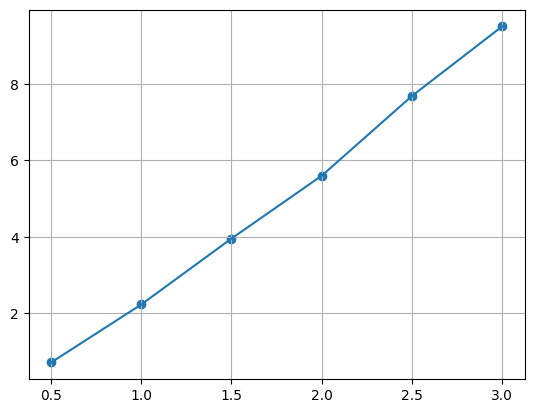

In [39]:
plt.plot(t_check, x_check)
plt.scatter(t_check, x_check)
plt.grid()